In [1]:
import numpyro
NCHAINS = 10
numpyro.set_host_device_count(NCHAINS)

import numpy as np
from os.path import join
from h5py import File
import matplotlib.pyplot as plt
import jax
from numpyro.infer import MCMC, NUTS, init_to_median

import candel


%load_ext autoreload
%autoreload 2

In [2]:
def convert_BTFR_Andreea(fname="/Users/rstiskalek/Projects/CANDEL/data/BTFR_Andreea/master_sample_bTFr_redshifts.csv"):
    d = np.genfromtxt(fname, delimiter=',', skip_header=1)
    RA = d[:, 1]
    dec = d[:, 2]
    zhelio = d[:, 3]
    Vcmb = candel.heliocentric_to_cmb(zhelio, RA, dec) * candel.SPEED_OF_LIGHT

    fname_save = fname.replace(".csv", "_genform.txt")
    print(f"Saving to `{fname_save}`")
    np.savetxt(fname_save, np.column_stack([RA, dec, Vcmb, zhelio]), header="RA dec Vcmb zhelio")

def write_BTFR_Andreea(fname, z_samples, which_LOS):
    # Read the generic file format
    d = np.genfromtxt(fname, names=True)
    RA = d["RA"]
    dec = d["dec"]
    zhelio = d["zhelio"]

    fname_save = fname.replace(".txt", f"_{which_LOS}.txt")

    zcosmo_mean = np.mean(z_samples, axis=1)
    zcosmo_std = np.std(z_samples, axis=1)

    print(f"Writing to `{fname_save}`.")
    with np.printoptions(precision=8, suppress=True):
        np.savetxt(
                fname_save,
                np.column_stack([RA, dec, zhelio, zcosmo_mean, zcosmo_std]),
                header="RA dec zhelio zcosmo_mean zcosmo_std"
            )

# convert_BTFR_Andreea()

### Quick check of the LOS velocities

In [3]:
fname_los = "/Users/rstiskalek/Projects/CANDEL/data/BTFR_Andreea/master_sample_bTFr_redshifts_genform_LOS_Carrick2015.hdf5"
with File(fname_los, 'r') as f:
    los_velocity_C15 = f['los_velocity'][...] * 0.47
    r_C15 = f['r'][...]

fname_los = "/Users/rstiskalek/Projects/CANDEL/data/BTFR_Andreea/master_sample_bTFr_redshifts_genform_LOS_manticore_2MPP_MULTIBIN_N256_DES_V2.hdf5"
with File(fname_los, 'r') as f:
    los_velocity_manticore = f['los_velocity'][...]
    r_manticore = f['r'][...]

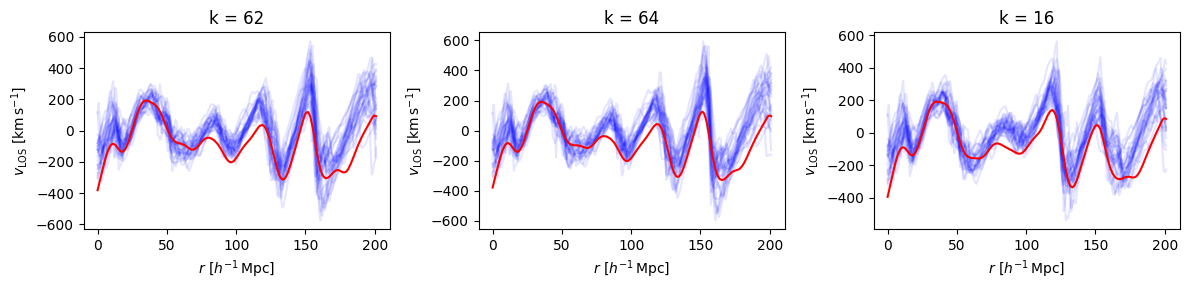

In [4]:
gen = np.random.default_rng(1232)
ks = gen.choice(67, size=3, replace=False)

plt.figure(figsize=(12, 3))

for i, k in enumerate(ks):
    plt.subplot(1, 3, i + 1)
    for j in range(30):
        plt.plot(r_manticore, los_velocity_manticore[j, k, :], c='blue', alpha=0.1)
    plt.plot(r_C15, los_velocity_C15[0, k, :], c='red')
    plt.xlabel(r"$r ~ [h^{-1}\,\mathrm{Mpc}]$")
    plt.ylabel(r"$v_{\rm LOS} ~ [\mathrm{km}\,\mathrm{s}^{-1}]$")
    plt.title(f"k = {k}")

plt.tight_layout()
plt.show()

In [5]:

fname = "/Users/rstiskalek/Projects/CANDEL/data/BTFR_Andreea/master_sample_bTFr_redshifts_genform.txt"
# fname_los = "/Users/rstiskalek/Projects/CANDEL/data/BTFR_Andreea/master_sample_bTFr_redshifts_genform_LOS_Carrick2015.hdf5"
fname_los = "/Users/rstiskalek/Projects/CANDEL/data/BTFR_Andreea/master_sample_bTFr_redshifts_genform_LOS_manticore_2MPP_MULTIBIN_N256_DES_V2.hdf5"

# fname_samples = "/Users/rstiskalek/Projects/CANDEL/results/VFO/precomputed_los_Carrick2015_CF4_W1_MNR_linear.hdf5"
fname_samples = "/Users/rstiskalek/Projects/CANDEL/results/precomputed_los_manticore_2MPP_MULTIBIN_N256_DES_V2_CF4_W1_noMNR_double_powerlaw_beta_1.0.hdf5"
num_downsample = 1000
which_bias = "double_powerlaw"

num_warmup = 500
num_samples = 2000

In [6]:
z2r  = candel.Distance2Redshift()
redshift2dist = candel.Redshift2Distance()

input_data = candel.pvdata.load_generic(fname, fname_los)
r_init = redshift2dist(input_data["zcmb"])
r_init = np.where(input_data["zcmb"] > 0, r_init, 5.0)

gen = np.random.default_rng(42)

keys_read = ["sigma_v", "Vext", "beta", "b1", "alpha_low", "alpha_high", "log_rho_t"]
with File(fname_samples, 'r') as f:
    grp = f["samples"]
    calibration_samples = {key: grp[key][...] for key in keys_read if key in grp}

calibration_keys = list(calibration_samples.keys())
num_calibration = calibration_samples[calibration_keys[0]].shape[0]
if num_downsample is not None and num_downsample < num_calibration:
    idx = gen.choice(num_calibration, size=num_downsample, replace=False)
    print(f"Downsampled calibration samples to {num_downsample} samples from {num_calibration}")
    for key in calibration_keys:
        calibration_samples[key] = calibration_samples[key][idx]


model_kwargs = {
    "RA": input_data["RA"],
    "dec": input_data["dec"],
    "zcmb": input_data["zcmb"],
    "r_init": r_init,
    "los_r": input_data["los_r"],
    "los_density": input_data["los_density"],
    "los_velocity": input_data["los_velocity"],
    "calibration_samples": calibration_samples,
    "which_bias": which_bias
}


r_from_z_obs = redshift2dist(input_data["zcmb"])

2025-11-06 22:35:20 loaded 67 galaxies from /Users/rstiskalek/Projects/CANDEL/data/BTFR_Andreea/master_sample_bTFr_redshifts_genform.txt.
2025-11-06 22:35:20 normalizing the Manticore LOS density (Om = 0.3111)
Downsampled calibration samples to 1000 samples from 5000


In [7]:
r_samples, rhat_sample = candel.redshift2real.run_batched_inference(
    model_kwargs, batch_size=5, num_warmup=num_warmup,
    num_samples=num_samples, num_chains=NCHAINS, rng_seed=1234,
    # galaxy_idx=1
    )

z_samples = z2r(r_samples)

if r_samples.ndim > 1:
    nprint = 10
    ks = np.argsort(rhat_sample)[::-1][:nprint]
    print(f"The {nprint} samples with the largest R-hat values have: \n{np.sort(rhat_sample)[::-1][:nprint]}")

2025-11-06 22:37:00 Running inference for 67 galaxies in 14 batches of size 5.


Processing batches:   0%|          | 0/14 [00:00<?, ?it/s]

Computing `double_powerlaw` bias lp normalization...
2025-11-06 22:37:01 Beta not in calibration samples. Setting beta=1.
2025-11-06 22:37:01 Loaded 5 objects and 1000 calibration samples.
Calibration sample statistics:
sigma_v : 144.302 +- 4.701
beta    : 1.000 +- 0.000
alpha_low  : 3.907 +- 0.413
alpha_high : 0.034 +- 0.033
log_rho_t  : 0.410 +- 0.213


Processing batches: 100%|██████████| 14/14 [13:02<00:00, 55.87s/it]

2025-11-06 22:50:02 Batched inference complete.
The 10 samples with the largest R-hat values have: 
[1.0041817 1.003872  1.0035151 1.0031077 1.0024375 1.0020853 1.0020685
 1.0019097 1.0018394 1.0017152]


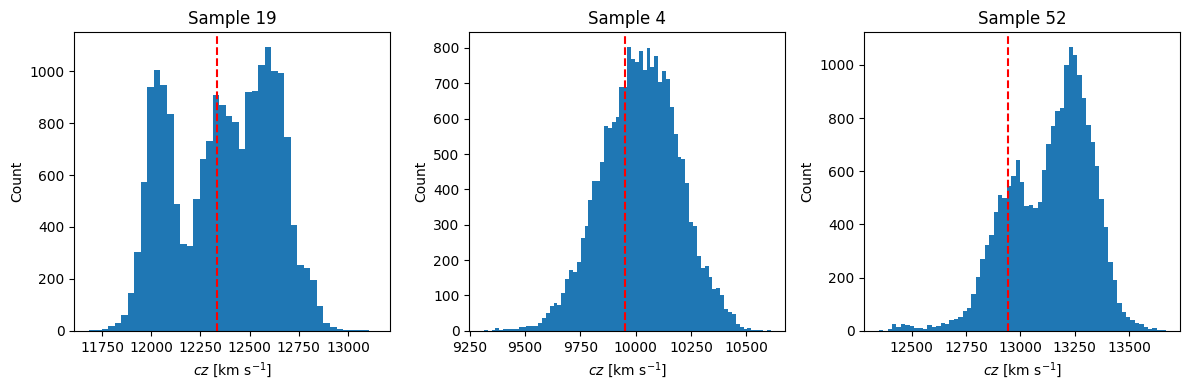

In [19]:
seed = None
np.random.seed(seed)

nshow = 3
idx = np.random.choice(z_samples.shape[0], nshow, replace=False)

plt.figure(figsize=(12, 4))

for j, i in enumerate(idx):
    plt.subplot(1, nshow, j + 1)
    plt.hist(
        candel.SPEED_OF_LIGHT * z_samples[i, :],
        bins="auto",
        color="C0"
    )
    plt.axvline(
        candel.SPEED_OF_LIGHT * input_data["zcmb"][i],
        color="red",
        linestyle="--",
        label=r"$c z_{\rm CMB}$"
    )
    plt.title(f"Sample {i}")
    plt.xlabel(r"$cz$ [km s$^{-1}$]")
    plt.ylabel("Count")

plt.tight_layout()
plt.savefig("/Users/rstiskalek/Downloads/BTFR_Andreea_zcosmo_samples.png", dpi=350)
plt.show()

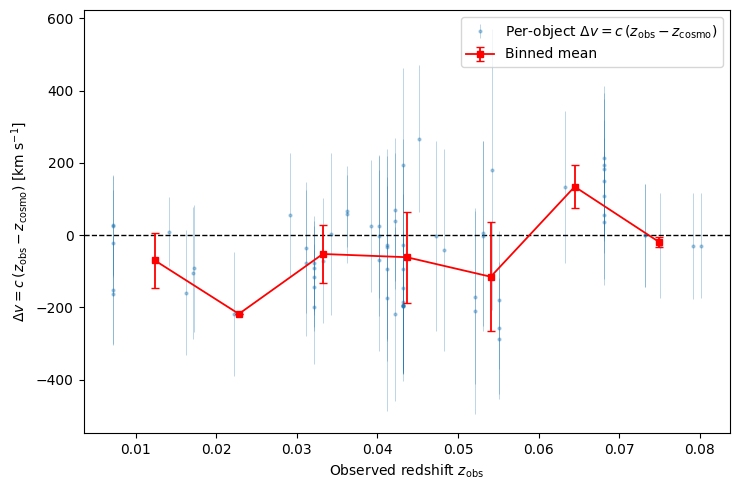

In [20]:
from scipy.stats import binned_statistic

# --- per-galaxy summary from samples ---
zcosmo_mean = np.mean(z_samples, axis=1)
zcosmo_std  = np.std(z_samples, axis=1)

# observed redshift
z_obs = np.asarray(input_data["zcmb"])

# convert redshift residuals to km/s
c = candel.SPEED_OF_LIGHT  # in km/s
v_diff = (z_obs - zcosmo_mean) * c
v_err  = zcosmo_std * c     # std also in km/s

# mask any NaNs
mask = np.isfinite(z_obs) & np.isfinite(v_diff) & np.isfinite(v_err)
z_obs = z_obs[mask]
v_diff = v_diff[mask]
v_err = v_err[mask]

# --- binning ---
nbins = 7
bins = np.linspace(z_obs.min(), z_obs.max(), nbins + 1)
bin_means, _, _ = binned_statistic(z_obs, v_diff, statistic='mean', bins=bins)
bin_stds,  _, _ = binned_statistic(z_obs, v_diff, statistic='std', bins=bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# --- plot ---
plt.figure(figsize=(7.5, 5))

# per-object scatter
plt.errorbar(
    z_obs, v_diff, yerr=v_err,
    fmt='o', ms=2, alpha=0.35, lw=0.6, color='C0', ecolor='C0',
    label=r'Per-object $\Delta v = c\,(z_{\rm obs} - z_{\rm cosmo})$'
)

# binned means
plt.errorbar(
    bin_centers, bin_means, yerr=bin_stds,
    fmt='s-', color='red', ms=4, lw=1.3, capsize=3, label='Binned mean',
    zorder=10,
)

plt.axhline(0, ls='--', c='k', lw=1)
plt.xlabel(r'Observed redshift $z_{\rm obs}$')
plt.ylabel(r'$\Delta v = c\,(z_{\rm obs} - z_{\rm cosmo})$ [km s$^{-1}$]')
plt.legend()
plt.tight_layout()
plt.savefig("redshift_residuals_vs_zobs.png", dpi=300)
plt.show()

In [21]:
write_BTFR_Andreea(fname, z_samples, which_LOS="Manticore")

Writing to `/Users/rstiskalek/Projects/CANDEL/data/BTFR_Andreea/master_sample_bTFr_redshifts_genform_Manticore.txt`.


In [27]:
with File(fname.replace(".txt", f"_samples_Manticore.hdf5"), 'w') as f:
    f.create_dataset("zcosmo_samples", data=z_samples)
    f.create_dataset("zcmb", data=input_data["zcmb"])
    f.create_dataset("RA", data=input_data["RA"])
    f.create_dataset("dec", data=input_data["dec"])

In [ ]:
# !cp /Users/rstiskalek/Projects/CANDEL/data/BTFR_Andreea/master_sample_bTFr_redshifts_genform_Carrick2015.txt ~/Downloads/